Term Project - Data Science course by Claudia Mendes, Laerte Sodre, and Zeljko Ivezik. 

In this python notebook, we explore exclusive (and not yet published) data from the Galactic disk. The idea is to find blue stars (and Be candidates, if possible) using clustering methods in proper motion space (using GAIA EDR3) in order to try to find stellar clusters. The .csv table produced using SPLUS and GAIA data were matched using TOPCAT.

The tools to find these stars and Be candidates are color-magnitude and color-color diagrams, based on what is published until now in the literature.

In [ ]:
pip install astroML

The first important thing is importing the common modules from python to work with scientific, astronomical data. And, obviously, sklearn to show results using Gaussian Mixture Method in our first attempt of clustering data (as we did in one of the course Lectures).

In [18]:
%matplotlib inline
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture as GMM
from astroML.plotting.mcmc import convert_to_stdev
from astroML.plotting import setup_text_plots
from astroML.datasets import fetch_moving_objects
from astroML.plotting.tools import draw_ellipse
from astroML.clustering import HierarchicalClustering, get_graph_segments
setup_text_plots(fontsize=8, usetex=False)
# random seed 
np.random.seed(5)

Now, with everything in hands, we can finally move into loading the table. I personally prefer working with .csv files, and using pandas dataframe. In this notebook section, the table is read using pandas.read_csv and cleaned using a function that removes any cell containing NaNs and infinities. The only collumns to be used are the broad bands magnitudes and the narrow H-alpha filter, Right Ascension and Declination, parallax, and proper motion coordinates in RA and DEc.

The clustering will be applied first in pmra and pmdec space. That's why I stack these two collums in the variable 'X'. Then, the plot of all data points is showed.

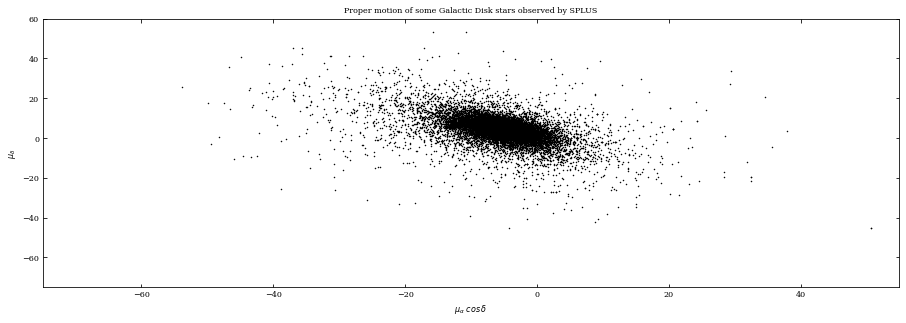

In [115]:
import pandas as pd

def clean_df(dataf):
    df = dataf
    assert isinstance(df, pd.DataFrame) 
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

data_path = 'term_project.csv'

data = pd.read_csv(data_path, usecols=['RAJ2000', 'DEJ2000', 'SPLUS_R', 'SPLUS_G', 'SPLUS_I', 'SPLUS_F660', 'SPLUS_U', 'SPLUS_Z', 'parallax', 'pmra', 'pmdec'])

clean_df(data)

pmra = data['pmra']
pmdec = data['pmdec']


X = np.vstack([pmra, pmdec]).T


# graphic configuration

xmin, xmax = (-75, 55)
ymin, ymax = (-75 , 60)

fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0, left=0.1, right=0.95, bottom=0.1, top=0.9)

ax = fig.add_subplot(311)
ax.scatter(X[:, 0], X[:, 1], s=1, lw=0.5, color='k')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel(r'$\mu_{\alpha} \, \, cos \, \delta$')
ax.set_ylabel(r'$\mu_{\delta}$')
ax.set_title('Proper motion of some Galactic Disk stars observed by SPLUS')

plt.show()




The first algorithm used is from sklearn (GMM - Gaussian Mixture Method). First, we define a function which will compute ahead 50 models, each one incrementing one component.

Then, the best model is the one with minimum BIC, calculated using sklearn functions.

In [ ]:
# Computation of Gaussian Mixture 

N = np.arange(1, 50) 
 
def compute_GMM(N, covariance_type='full', max_iter=100):
  models = [None for n in N]
  for i in range(len(N)):
    models[i] = GMM(n_components=N[i], max_iter = max_iter, 
                    covariance_type=covariance_type)
    models[i].fit(X)
  return models

models = compute_GMM(N)
BIC = [m.bic(X) for m in models]
i_best = np.argmin(BIC)

gmm_best = models[i_best]


The results are plotted below. We can see that GMM doesn't go as we want. As everybody says: "The computer only does what he is told to do". But these groups formed aren't what we want them to be. 

Another thing that we need to do in order to find real stellar clusters is take into account distances. Members of a stellar cluster need to be in roughly the same distance (or in the same order, let's say, in parsecs). 

This is something I couldn't finish by now. However, I really want to proceed here in this notebook using what we found so far, because stellar clusters can also be found and separated when we move into the color diagrams.

In [ ]:
# Plotting the results of GMM

fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(wspace=0.45, bottom=0.25, top=0.9, left=0.1, right=0.97)

ax = fig.add_subplot(211)

ax.scatter(pmra, pmdec, c='red', s=1, lw=0)

ind = np.argsort(gmm_best.weights_)[::-1]
for cnt, i in enumerate(ind[:N[i_best]]):
    mu = gmm_best.means_[i]
    C = gmm_best.covariances_[i]
    w = gmm_best.weights_[i]
    print(cnt, i, w)
    # the 20 most numerous clusters in blue
    if (cnt<20):
        draw_ellipse(mu, C, scales=[1.0], ax=ax, fc='none', lw=1.0, ec='blue')
    else:
        draw_ellipse(mu, C, scales=[1.0], ax=ax, fc='none', lw=0.5, ec='k')

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel(r'$\mu_{\alpha} \, \, cos \, \delta$')
ax.set_ylabel(r'$\mu_{\delta}$')

plt.show()

These results with GMM are similar to what we found in the original lecture of the course. I wanted to use as an alternative the Mininum Spanning Tree model because of how simple it is to handle and configurate.

In [4]:
# The GMM results are quite.. strange. We know that searching
# for clusters (open or globular) we need really close points
# in the proper motion space. Let's check the MS Tree model

n_neighbors = 10
edge_cutoff = 0.9
cluster_cutoff = 10

model = HierarchicalClustering(n_neighbors=n_neighbors, edge_cutoff=edge_cutoff,
                               min_cluster_size=cluster_cutoff)

model.fit(X)

n_components = model.n_components_
labels = model.labels_
#------------------------------------------------------------
# Get the x, y coordinates of the beginning and end of each line segment

T_x, T_y = get_graph_segments(model.X_train_,
                              model.full_tree_)
T_trunc_x, T_trunc_y = get_graph_segments(model.X_train_,
                                          model.cluster_graph_)

Now, we move to the plots of the tree algorithm results. Most of these sections can take a really long time to calculate, as we are dealing with more than 2e6 points.

In [ ]:
# Plotting the alternate results

fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(hspace=0, left=0.1, right=0.95, bottom=0.1, top=0.9)

ax = fig.add_subplot(311)
ax.scatter(X[:, 0], X[:, 1], s=1, lw=0.5, color='k')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel(r'$\mu_{\delta}$')

ax = fig.add_subplot(312)
ax.scatter(X[:, 0], X[:, 1], s=1, lw=0.8, c='k')
ax.plot(T_x, T_y, c='red', lw=0.8)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylabel(r'$\mu_{\delta}$')

ax = fig.add_subplot(313)
ax.scatter(X[:, 0], X[:, 1], s=1, lw=0.8, c='k')
ax.plot(T_trunc_x, T_trunc_y, c='red', lw=0.8)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel(r'$\mu_{\alpha} \, \, cos \, \delta$')
ax.set_ylabel(r'$\mu_{\delta}$')

plt.show()

They look way more cleaner than GMM. However, it would be even more beautiful if I manage somehow to include parallax weighting...

From both methods plots, we can surely tell the expected range of points. This is done below selecting the table rows containing pmra and pmdec values inside the wanted range. So, the useful lists are created and append the wished values.

In the end, I transform these color + parallax lists into numpy arrays, calculate GAIA distances in parsecs using parallax of the remaining points, and calculate the color indices (U - G), (G - R), (R - I), and (I-Z). As these colors observed by SPLUS are based on SDSS magnitudes, I planned to use them to obtain Johnsons UBV and Cousins RI magnitudes, based on Lupton (2005).

The uncertainty of the transformation is really low, and we can at least see trends and compare to the literature, as most of the know and reliable studies from Be stars uses the most common magnitude system.

In [106]:
# Now we have to remember that we got out the wanted values from
# the dataframe. Let's rename them, and select from the dataframa the 
# indices from which these points are, and redo the df.

# pmra: between -18 and 4
# pmdec: between -15 and 15

pmra, pmdec = np.array(pmra), np.array(pmdec)
zcolor = []
ucolor = []
gcolor = []
icolor = []
rcolor = []
Hacolor = []
RAJ, DECJ = [], []
parallax1 = []

for idx in range(len(pmra)):
  if ((pmra[idx] < 4) and (pmra[idx] > -18)):
    if ((pmdec[idx] < 15) and (pmdec[idx]>-15)):
      try:
        ucolor.append(data['SPLUS_U'][idx])
        gcolor.append(data['SPLUS_G'][idx])
        rcolor.append(data['SPLUS_R'][idx])
        icolor.append(data['SPLUS_I'][idx])
        zcolor.append(data['SPLUS_Z'][idx])
        Hacolor.append(data['SPLUS_F660'][idx])
        RAJ.append(data['RAJ2000'][idx])
        DECJ.append(data['DEJ2000'][idx])
        parallax1.append(data['parallax'][idx])
      except KeyError:
        continue

ucolor, gcolor = np.array(ucolor), np.array(gcolor)
rcolor, icolor = np.array(rcolor), np.array(icolor)
zcolor = np.array(zcolor)
Ha = np.array(Hacolor)


u_g = ucolor - gcolor
g_r = gcolor - rcolor
r_i = rcolor - icolor
i_z = icolor - zcolor

# Transformations to Johnsons & Cousins system (Lupton 2005)

B = ucolor - 0.8116*(u_g) + 0.1313   # sigma = 0.0095
V = gcolor - 0.5784*(g_r) - 0.0038   # sigma = 0.0054
R = rcolor - 0.2936*(r_i) - 0.1439   # sigma = 0.0072
I = icolor - 0.3780*(i_z) - 0.3974   # sigma = 0.0063



These CC diagrams below does remove outliers (data points observed by SPLUS with magnitude equal to 99, which means they weren't reliable or couldn't be reduced). 

Also, we focus on realistic ranges from (B - V), (V - I) and V magnitude based on what is found in the literature for Be stars.

For instance, we look mainly for stars with (B - V) between [-0.4, 0.75], and (V - I) between [-0.81, 1.35]. Be stars when they present a circumstellar disk, tend to show a mix of their blue contribution and also optical light coming from hydrogen emission coming from the disk gaseous material. 

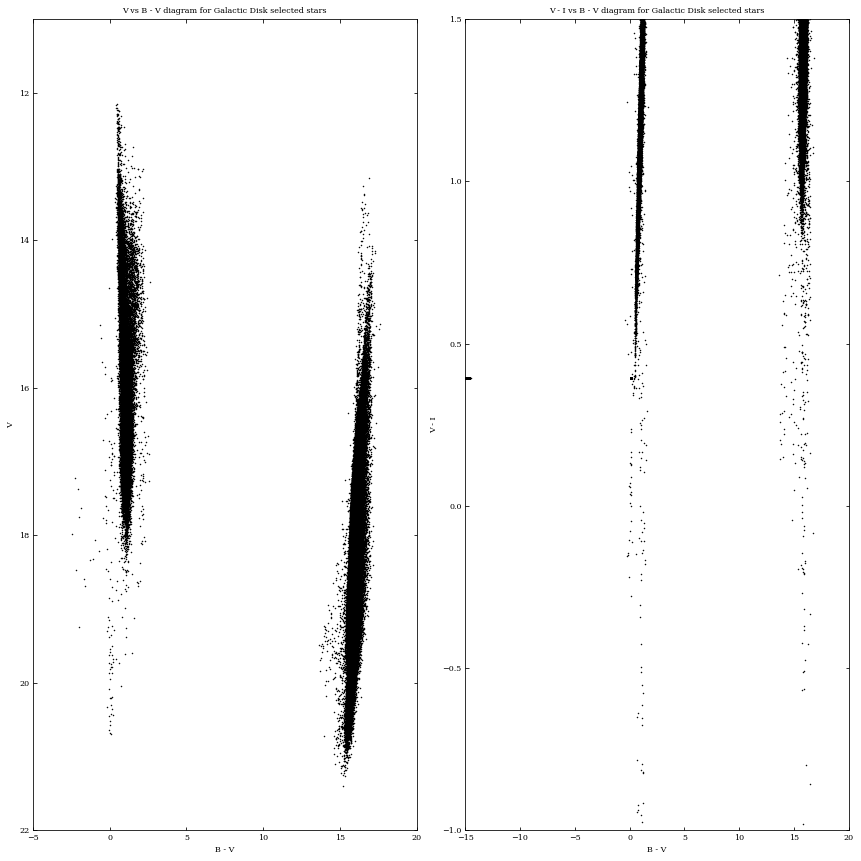

In [97]:
# Plotting Color-Color diagrams

fig = plt.figure(figsize=(12,12))

ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

BV = B - V
VI = V - I
RHa = R - Ha

ax1.scatter(BV, V, s=1, lw=0.5, color='k')
ax1.set_xlabel('B - V')
ax1.set_ylabel('V')
ax1.set_xlim(-5, 20)
ax1.set_ylim(11, 22)
ax1.invert_yaxis() 

ax1.set_title('V vs B - V diagram for Galactic Disk selected stars')

ax2.scatter(BV, VI, s=1, lw=0.5, color='k')
ax2.set_xlabel('B - V')
ax2.set_ylabel('V - I')
ax2.set_xlim(-15, 20)
ax2.set_ylim(-1, 1.5)

ax2.set_title('V - I vs B - V diagram for Galactic Disk selected stars')
plt.tight_layout()
plt.show()


We can see from the most realistic data two groups, one really reddish, and the other may present young stars (with B close to zero and negative values). But there is a third plot we can use to make a second clustering attempt to select these candidates. 

The final CC diagram we can use is (R - Halpha) vs (V - I). This plot can show us stars with H-alpha possible emission (points above the black horizontal line). So, we can try to find data from above the line, with (B - V) and (V - I) values inside the most found range in the Galaxy. 

PS: I am only taking into account Milky Way Be stars studies, as the metallicity may change things. There are several open questions about metallicity implications on B/Be star populations. Papers regarding this use for example stars found nearby the Galaxy, such as in the Small Magellanic Cloud and Large Magellanic Cloud (SMC and LMC).

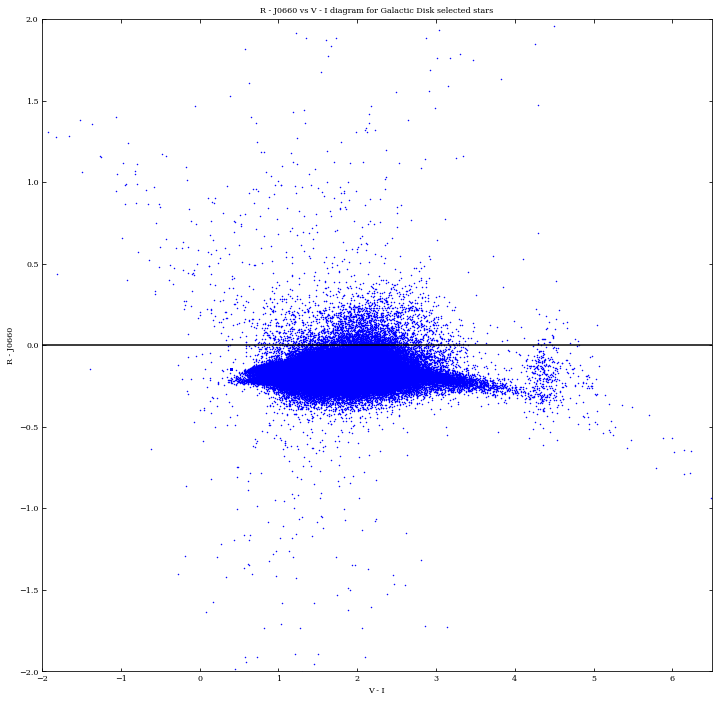

In [38]:
fig = plt.figure(figsize=(12,12))

plt.scatter(VI, RHa, s=1, lw=0.5, color='blue')
plt.xlim(-2, 6.5)
plt.ylim(-2, 2)

plt.xlabel('V - I')
plt.ylabel('R - J0660')

plt.hlines(0, -2, 6.5)

plt.title('R - J0660 vs V - I diagram for Galactic Disk selected stars')

plt.show()

We can now just select data points inside our wanted range. These will be candidates. However, it is really possible that none of them are in fact, Be (or even B) stars.

The procedure after this, for example in a deep study, would be to try finding these stars in the literature, crossmatching with SIMBAD for instance.

Another thing is: If every one of these found stars are not even close to main sequence B type stars (or O9 and A0), which we can know using theoretical tracks in Color-Magnitude diagrams (if we make the initial proper motion clustering taking into account the distances), then it would be waste of effort moving to spectroscopic follow-up.

Andre's project used data from the SMC and LMC, and he crossmatched data with observations from OGLE, and we found together know Be stars looking into the WEBDA database of open clusters, which for many it contains known Be stars for sure.

In [ ]:
RA = []    # coordinates in ICRS system (epoch = 2000)
DEC = []
parallax = []

for idx in range(len(BV)):
  if ((BV[idx] < 0.75) and (BV[idx] > -0.4)):
    if ((VI[idx] < 1.35) and (VI[idx]>-0.81)):
      if (RHa[idx] > 0):
        try:
          RA.append(RAJ[idx])
          DEC.append(DECJ[idx])
          parallax.append(parallax1[idx])
        except KeyError:
          continue

parallax = np.array(parallax)

distance = abs(1000/parallax)   # in parsecs 

#RA, DEC = np.array(RA), np.array(DEC)


In [114]:
distance_list = []
for i in range(len(distance)):
  distance_list.append(distance[i])

distance = sorted(distance)

print(distance)

[149.81273408239701, 157.82828282828282, 157.87811809283235, 173.47558331164888, 176.08113818847727, 185.6665428889714, 197.67924565599859, 212.98800877510595, 237.14102776921436, 242.9366178364065, 245.51927326295112, 250.06876891145066, 253.01723047339522, 263.3519435373433, 269.73808432012515, 270.8265626692666, 271.88689505165854, 276.5945676826907, 290.1662652699997, 292.9887785297823, 295.2814031772279, 299.18621349928196, 302.64511833424126, 304.1455032087351, 305.7262527133205, 309.2624091541673, 312.6367785906334, 313.2537668765467, 313.74517616791644, 316.8567807351077, 320.3690651630679, 320.5230936889003, 323.185314459311, 325.27729889730995, 330.02211148146927, 332.24798989966115, 340.11291748860623, 341.76349965823647, 344.2222298716051, 344.3051921222972, 344.53057708871665, 346.4043231259526, 348.8453219842322, 350.2381619501261, 354.58478122119, 359.557025744283, 363.1082062454612, 363.57025995273585, 366.3540445486518, 370.7273670942389, 372.1484127870195, 372.4117384

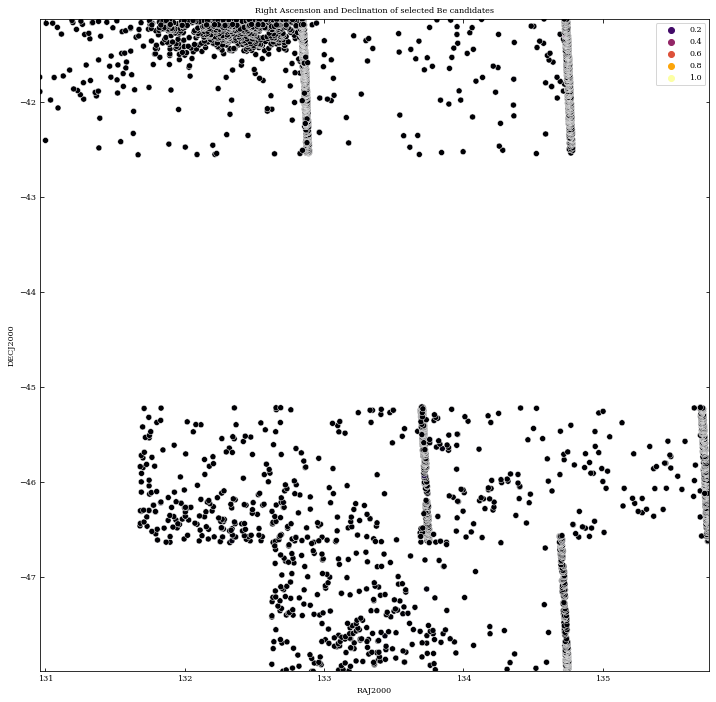

In [109]:
fig = plt.figure(figsize=(12,12))

#plt.scatter(RA, DEC, s=2, lw=0.5, c=distance_list, cmap='jet')
#plt.colorbar()

sns.scatterplot(x=RA, y=DEC, hue=distance_list, palette= sns.color_palette("inferno", 10, as_cmap=True))

plt.xlabel('RAJ2000')
plt.ylabel('DECJ2000')

plt.title('Right Ascension and Declination of selected Be candidates')

plt.show()

Above, we can see for instance that one distance is 10 mi parsec, which does not reflect on what we wish to see. And, there is another thing: many distances from GAIA, even in EDR3, contains a large parallax error, so inverting parallax is not reliable anymore. Another thing is: I did not take away negative values from parallax, which can be another factor of contamination.

For a more reliable graphing, we need to filter every nonsense data from our analysis. Sorting the selected distances, the mean is close to 9 kpc, and the median of the selected sample (approx 5 thousand stars) is close to 2 kpc. So most of the distance values are okay in some way.

One very interesting thing to do after selecting even better targets, is to transform these coordinates into Galactic ones, in order to plot a celestial sphere graph centered either on the Sun, or at the Galactic center (considering a mean value of Galactic radius of 8 kpc, for example).

I wish I could have done more in this term project. I had many ideas that couldn't be finished or even put in practice because of the time spent on the MSc main project. 

However, there are so many tools we learned through this data science course that I am deeply sure we won't find better material and classes for all given themes.

Items that I consider good to improve this method:
- Filtering well the distance estimation based on parallax_over_error GAIA parameter;
- When considering different parts of the sky when observing Galactic fields, make sure to use a very good clustering algorithm in proper motion space (if finding open/globular clusters is a wish), such as K-means if you suspect what is the expected number of clusters or Minimun Spanning Tree if there is one main cluster of objects;
- Make the plots even nicer, for publishing intentions;
- Try to apply another method to select and present better the candidates data with B-V, V-I and R-J0660 inside the wanted ranges, such as PCA, instead of a big if statement.

Considerations: I want to thank again all main Professors giving this course, with very complete lectures and hands-on activities presented in only two weeks. I want to thank SPLUS, with special attention to Claudia and Felipe, that gave me unpublished data from the Galactic disk and Andre data from the clouds. We are certain that in the near future, many results will arise using this multi-band photometry in the Be stars area.

Pedro Ticiani dos Santos

MSc Student

Universidade de São Paulo

Departamento de Astronomia
